# Opening Middle Eastern Restaurants in Houston City

### Introduction

The main objective of this project is to analyze the areas in Houston city where Middle Eastern Restaurants are available in order to select the optimum location for a new restaurant. The selection will be based on teh nighborhood with minimum number of restaurants. The analysis will be shared with stakeholders to confirm the location selection.

### Data Collection

#### Geographical Coordinates
The geographical coordinates for Houston will be gathered from Python GeoPy library in python.

#### Neighborhoods information:
The data of the neighborhoods in Houston was collected from was scraped from https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods. The data will be converted into pandas data frame.

#### Venue information:
The venue data will collected from Foursquare API.

In [1]:
import numpy as np
import pandas as pd
import json
!pip install geopy
!pip install geocoder
from geopy.geocoders import Nominatim
import geocoder
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install folium
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.metrics import silhouette_score

%matplotlib notebook

print('Done')

     |████████████████████████████████| 98 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 94 kB 5.0 MB/s  eta 0:00:01
Done


Reteriving the data of the Neighborhoods and identify the different location Values

In [191]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_Houston_neighborhoods')[0]
df.rename(columns={'Name': 'Neighborhood', 'Location relative to Downtown Houston':'Location'}, inplace=True)
df.pop('Approximate boundaries')
df.pop('#')
df.head(10)

,Neighborhood,Location
0,Willowbrook,Northwest
1,Greater Greenspoint,North
2,Carverdale,Northwest
3,Fairbanks / Northwest Crossing,Northwest
4,Greater Inwood,Northwest
5,Acres Home,Northwest
6,Hidden Valley,North
7,Westbranch,West
8,Addicks / Park Ten,West
9,Spring Branch West,West


In [192]:
df['Location'].value_counts()

Southwest    15
Southeast    14
Northwest    12
West         12
Northeast    11
South        11
North         6
East          6
—             1
Name: Location, dtype: int64

Adjusting the location data to reflect the Downtown

In [193]:
for index in df.index:
    if df.loc[index,'Neighborhood']=='Downtown':
        df.loc[index,'Location'] = 'Downtown'
  

In [194]:
df['Location'].value_counts()

Southwest    15
Southeast    14
Northwest    12
West         12
Northeast    11
South        11
North         6
East          6
Downtown      1
Name: Location, dtype: int64

In [196]:
df['Latitude'] = None
df['Longitude'] = None

for i, neigh in enumerate(df['Neighborhood']):
    lat_lng_coords = None
    
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Houston'.format(neigh))
        lat_lng_coords = g.latlng
    
    if lat_lng_coords:
        latitude = lat_lng_coords[0]
        longitude = lat_lng_coords[1]
    
    df.loc[i, 'Latitude'] = latitude
    df.loc[i, 'Longitude'] = longitude

df.head(10)

,Neighborhood,Location,Latitude,Longitude
0,Willowbrook,Northwest,29.9524,-95.5446
1,Greater Greenspoint,North,29.9397,-95.4075
2,Carverdale,Northwest,29.8496,-95.5424
3,Fairbanks / Northwest Crossing,Northwest,29.8494,-95.5109
4,Greater Inwood,Northwest,29.8698,-95.4804
5,Acres Home,Northwest,29.8705,-95.4354
6,Hidden Valley,North,29.8885,-95.4146
7,Westbranch,West,29.8394,-95.5536
8,Addicks / Park Ten,West,29.8143,-95.6159
9,Spring Branch West,West,29.8011,-95.5493


### Now we will visualize the Data

In [199]:
neighborhood_Houston = df.groupby('Location')['Neighborhood'].nunique()
neighborhood_Houston

Location
Downtown      1
East          6
North         6
Northeast    11
Northwest    12
South        11
Southeast    14
Southwest    15
West         12
Name: Neighborhood, dtype: int64

<IPython.core.display.Javascript object>


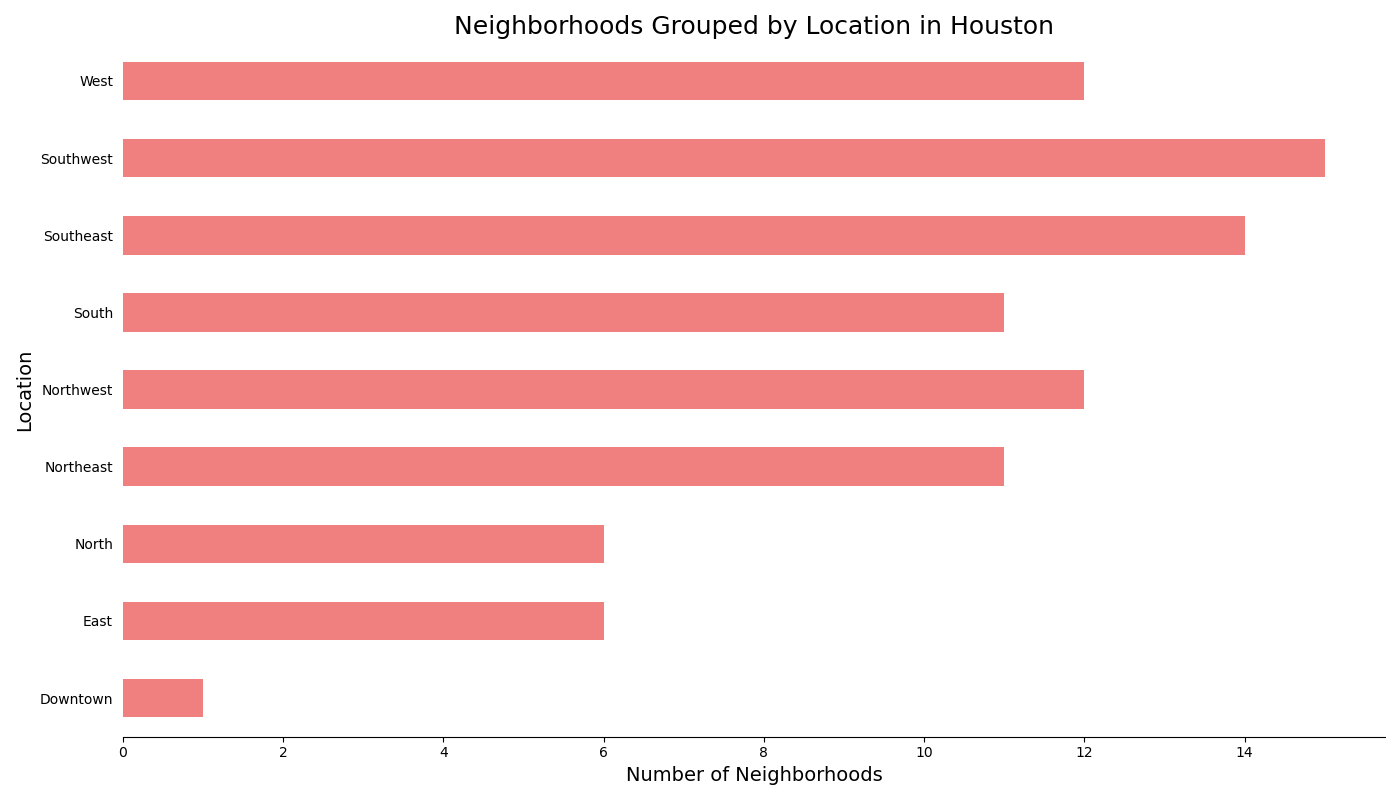

In [200]:
fig = plt.figure(figsize=(14,8))

ax = neighborhood_Houston.plot(kind='barh', color='lightcoral')
ax.set_title('Neighborhoods Grouped by Location in Houston', fontsize=18)
ax.set_xlabel('Number of Neighborhoods', fontsize=14)
ax.set_ylabel('Location', fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(which='major', left=False)

fig.tight_layout()

In [201]:
address = 'Houston, USA'
geolocator = Nominatim(user_agent='daifmoh@gmail.com')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Houston are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Houston are 29.7589382, -95.3676974.


In [202]:
map_Houston = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, location, neighborhood in zip(df['Latitude'], df['Longitude'], df['Location'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='Blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Houston)  
    
map_Houston

##### The venue Analysis will be done from Houston Downtown 

In [203]:
neighborhood_name = df.loc[60, 'Neighborhood']
neighborhood_lat = df.loc[60, 'Latitude']
neighborhood_long = df.loc[60, 'Longitude']

print("The neighborhood is {} and it's Geographical coordinates are {} latitude and {} longitude".format(neighborhood_name,neighborhood_lat, neighborhood_long))

The neighborhood is Downtown and it's Geographical coordinates are 29.756260000000054 latitude and -95.35655999999994 longitude


Now Will gather information about venues from Foursquare

In [204]:
CLIENT_ID = 'GTB2I3BTPHA0LFVNR1PXABL4A4LICUJ1H1JU3HI1UWRIVDRM' # my Foursquare ID
CLIENT_SECRET = 'T3ECK55FTGRIWW0IQGCHEDUDWN2VXDSYWSLEK01CRT33KSSB' # my Foursquare Secret
ACCESS_TOKEN = '9d96b09ba0c291a9b2bcf9bc51ab810775396a97' # my FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GTB2I3BTPHA0LFVNR1PXABL4A4LICUJ1H1JU3HI1UWRIVDRM
CLIENT_SECRET:T3ECK55FTGRIWW0IQGCHEDUDWN2VXDSYWSLEK01CRT33KSSB


The results will be gathered for venues that offer italian food within 5 KM radius from Houston Downtown center

In [234]:
LIMIT = 100
radius = 5000

url = 'https://api.foursquare.com/v2/venues/explore?client_id=GTB2I3BTPHA0LFVNR1PXABL4A4LICUJ1H1JU3HI1UWRIVDRM&client_secret=T3ECK55FTGRIWW0IQGCHEDUDWN2VXDSYWSLEK01CRT33KSSB&ll=29.756260000000054,-95.35655999999994&vauth_token=9d96b09ba0c291a9b2bcf9bc51ab810775396a97&v=20180604&query=Italian%20Restaurant&radius=5000&limit=100'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_long, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=GTB2I3BTPHA0LFVNR1PXABL4A4LICUJ1H1JU3HI1UWRIVDRM&client_secret=T3ECK55FTGRIWW0IQGCHEDUDWN2VXDSYWSLEK01CRT33KSSB&ll=29.756260000000054,-95.35655999999994&vauth_token=9d96b09ba0c291a9b2bcf9bc51ab810775396a97&v=20180604&query=Italian%20Restaurant&radius=5000&limit=100'

In [235]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '6005e34d4c759760acf33a81'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Houston',
  'headerFullLocation': 'Houston',
  'headerLocationGranularity': 'city',
  'query': 'italian restaurant',
  'totalResults': 45,
  'suggestedBounds': {'ne': {'lat': 29.8012600450001,
    'lng': -95.30482204634153},
   'sw': {'lat': 29.71125995500001, 'lng': -95.40829795365836}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b510fe4f964a520554027e3',
       'name': 'Perbacco',
       'location': {'address': '700 Milam St',
        'lat': 29.760257437720647,
        'lng': -95.36477339516325,
        'labeledLatLngs': [{

In [236]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [237]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues)

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Perbacco,Italian Restaurant,29.760257,-95.364773
1,Grotto Downtown,Italian Restaurant,29.753918,-95.357197
2,Quattro,Italian Restaurant,29.754122,-95.362469
3,Potente,Italian Restaurant,29.757238,-95.357447
4,Birraporetti's,Italian Restaurant,29.762462,-95.364670


In [238]:
print("{} venues were returned for {} by Foursquare".format(len(nearby_venues), neighborhood_name))

45 venues were returned for Downtown by Foursquare


#### List of the venues will be generated

In [239]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, Latitude, Longitude in zip(names, latitudes, longitudes):
        print(name)

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id=GTB2I3BTPHA0LFVNR1PXABL4A4LICUJ1H1JU3HI1UWRIVDRM&client_secret=T3ECK55FTGRIWW0IQGCHEDUDWN2VXDSYWSLEK01CRT33KSSB&ll=29.756260000000054,-95.35655999999994&radius=5000&limit=100'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            Latitude, 
            Longitude, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['Latitude'], 
            v['venue']['location']['Longitude'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [240]:
print(nearby_venues.shape)
nearby_venues.head(10)

(45, 4)


,name,categories,lat,lng
0,Perbacco,Italian Restaurant,29.760257,-95.364773
1,Grotto Downtown,Italian Restaurant,29.753918,-95.357197
2,Quattro,Italian Restaurant,29.754122,-95.362469
3,Potente,Italian Restaurant,29.757238,-95.357447
4,Birraporetti's,Italian Restaurant,29.762462,-95.364670
5,Your Pie,Italian Restaurant,29.751770,-95.368600
6,Brooklyn Meatball Company,Italian Restaurant,29.757325,-95.365266
7,Mandola's Deli,Italian Restaurant,29.737454,-95.339587
8,Luigi's Pizzeria,Italian Restaurant,29.735450,-95.374640
9,Osso & Kristalla,Italian Restaurant,29.757451,-95.357903


### A map will be created to have better visualization of the restaurants distrubtion around the City

In [242]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centered from the center of the city

# add a red circle marker to represent the Conrad Hotel
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

# Results and Conculstion 